In [1]:
import matplotlib.pyplot as plt
import numpy as np

from qibo import callbacks, hamiltonians, models, set_backend, gates
set_backend("numpy")

[Qibo 0.1.15|INFO|2023-07-12 16:34:03]: Using numpy backend on /CPU:0


## Adiabatic Quantum Computing
In adiabatic quantum computing (AQC), contrary to the gate model, the computation starts from an initial Hamiltonian $H_0$ with a
ground state easy to prepare and we let the system evolve to a final Hamiltonian $H_1$ whose ground state encodes the solution to
a computational problem. The Hamiltonian for the system is the following:
$$ H(t) = ( 1 - s(t)) H_0 + s(t) H_1 $$

where $s(t) : [ 0, t_f ] \rightarrow [ 0,1]$ is know as the *schedule* and $t_f$ is the smallest time that guarantees
that the final state of $H(t)$ is "closed" to the ground state of $H_1$.  


For more information about AQC you can have a look at this [review](https://arxiv.org/abs/1611.04471).

### First example
In this first example we are going to code in Qibo an adiabatic evolution from a non-interacting Pauli-X Hamiltonian $H_X$ to a transverse field Ising model $H_{TFIM}$ which are defined as:

$$ H_X = - \sum_{i=0}^{N} X_i $$
$$ H_{TFIM} = - \sum_{i=0}^{N} (Z_i Z_{i+1} + h X_i) $$


Lets start by defining the two hamiltonians. You can find the hamiltonians avialable in Qibo [here](https://qibo.science/qibo/stable/api-reference/qibo.html#hamiltonians).

In [2]:
nqubits = 4
hfield = 1
h0 = hamiltonians.X(nqubits)
h1 = hamiltonians.TFIM(nqubits, h=hfield)

We can manipulate a Hamiltonian object by asking for:
* the [ground state](https://qibo.science/qibo/stable/api-reference/qibo.html#qibo.hamiltonians.abstract.AbstractHamiltonian.ground_state)
* the [eigenvectors](https://qibo.science/qibo/stable/api-reference/qibo.html#qibo.hamiltonians.Hamiltonian.eigenvectors)
* the [eigenvalues](https://qibo.science/qibo/stable/api-reference/qibo.html#qibo.hamiltonians.Hamiltonian.eigenvalues)
* the [expectation](https://qibo.science/qibo/stable/api-reference/qibo.html#qibo.hamiltonians.Hamiltonian.expectation) value of an arbitrary state


## Exercise
Check if the expectation value of the ground state is equal to the lowest eigenvalues with Qibo.

To check if two arrays are sufficiently close to each other you can use [`np.testing.assert_allclose`](https://numpy.org/doc/stable/reference/generated/numpy.testing.assert_allclose.html).

In [3]:
ground_state_energy = np.min(h1.eigenvalues())
ground_state = h1.ground_state()
ground_state_expectation = h1.expectation(ground_state)
np.testing.assert_allclose(ground_state_energy, ground_state_expectation)

We can perform the adiabatic evolution by allocating the [`AdiabaticEvolution`](https://qibo.science/qibo/stable/api-reference/qibo.html#adiabatic-evolution) object. We will start by defining a linear scheduling $s(t) = t$.

In [4]:
evolution = models.AdiabaticEvolution(
    h0, h1, lambda t: t, dt=1e-2, 
)

In [5]:
final_state = evolution(final_time=10)

We can track some quantities during the evolution by making use of [`Callbacks`](https://qibo.science/qibo/stable/api-reference/qibo.html#callbacks). In our case we might be interesting in tracking the expectation value of $H_1$ and the overlap with its ground state.

In [6]:
energy = callbacks.Energy(h1)
overlap = callbacks.Overlap(ground_state)
evolution = models.AdiabaticEvolution(
    h0, h1, lambda t: t, dt=1e-1, callbacks=[energy, overlap]
)
final_psi = evolution(final_time=10)

In [7]:
def plot_overlaps(T, energy, overlap, ground_state_energy, dt=1e-1):
    tt = np.linspace(0, T, int(T / dt) + 1)
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.plot(tt, energy[-len(tt):], linewidth=2.0, label="Evolved state")
    plt.axhline(y=ground_state_energy, color="red", linewidth=2.0, label="Ground state")
    plt.xlabel("$t$")
    plt.ylabel("$H_1$")
    plt.legend()

    plt.subplot(122)
    plt.plot(tt, overlap[-len(tt):], linewidth=2.0)
    plt.xlabel("$t$")
    plt.ylabel("Overlap")
    plt.show()

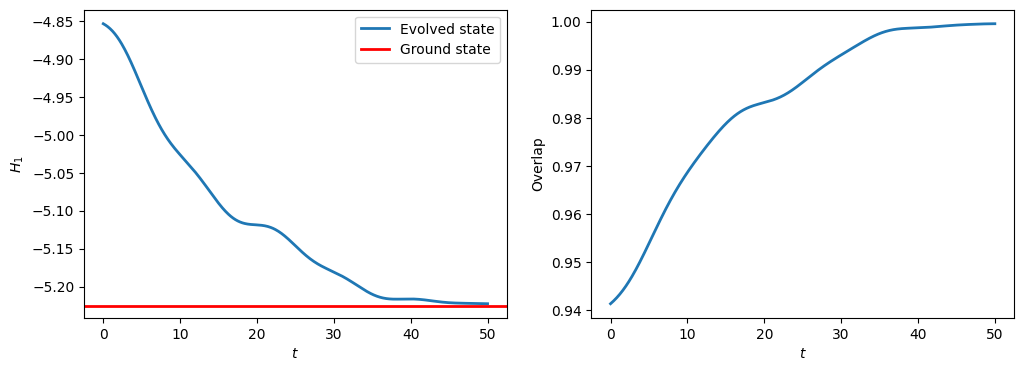

In [25]:

plot_overlaps(50, energy, overlap, ground_state_energy)

### Scheduling optimization
Can we do better than 10 as the final time?

We can try to use something more complicated than a linear scaling...

We can use a general polynomial scheduler and we can [optimize](https://qibo.science/qibo/stable/api-reference/qibo.html#qibo.models.evolution.AdiabaticEvolution.minimize) the parameters.

$$ s(t, p_0, \dots, p_{n-1}) = \Big( 1 - \sum_{i=0}^{n-1} p_i\Big) t + \sum_{i=0}^{n-1} p_i t^{i+2}$$

In [11]:
def spolynomial(t, params):
    """General polynomial scheduling satisfying s(0)=0 and s(1)=1"""
    f = sum(p * t ** (i + 2) for i, p in enumerate(params))
    f += (1 - np.sum(params)) * t
    return f

In [12]:
params = [1,1] # parms[-1] is the total_time
energy = callbacks.Energy(h1)
overlap = callbacks.Overlap(ground_state)
evolution = models.AdiabaticEvolution(h0, h1, spolynomial, dt=1e-2, callbacks=[energy, overlap])
best_energy, parameters, _ = evolution.minimize(params)

In [20]:
T = parameters[-1]
final_psi = evolution(9)

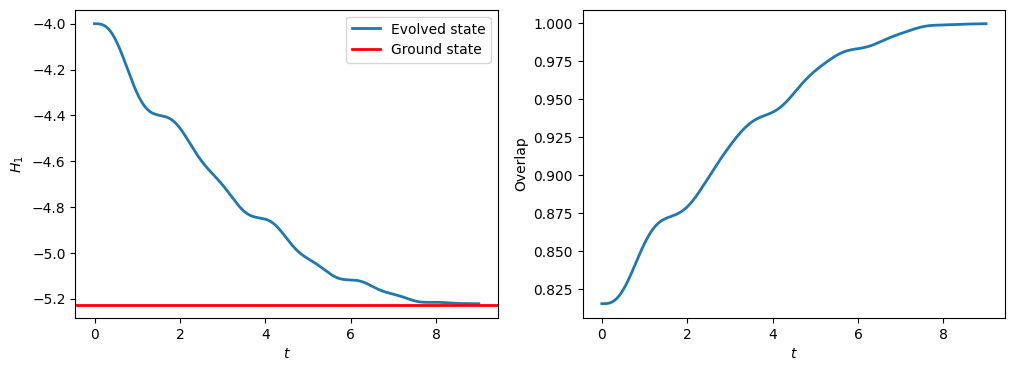

In [21]:
plot_overlaps(9, energy, overlap, ground_state_energy, dt=1e-2)

## Adiabatic Grover
It is possible to develop the Grover algorithm also using AQC.

We can denote the marked item by its binary representation $m$. We encode this state in the following Hamiltonian

$$H_1 = I - \ket{m}\bra{m}$$ 

The ground state of this Hamiltonian is 0.
To set up the adiabatic Grover algorithm we can start from the Hamiltonian $H_0 = I - \ket{\phi}\bra{\phi}$ where $\phi$ is the 
uniform superposition state that we encounter before

$$ \ket{\phi} = \frac{1}{\sqrt{N}} \sum_{i=0}^{N-1} \ket{i}$$

Therefore we end up with the following time-dependent Hamiltonian

$$ H(t) = [ 1 - A(s) ] H_0 + A(s) H_1 = $$

where $s = t/t_f$ and $A(s)$ is the scheduler.
We can find more about the adiabatic grover algorithm [here](https://arxiv.org/abs/quant-ph/0107015)

### Exercise:

Write the Adiabatic Grover algorithm (for two qubits) using Qibo first using a linear scheduler and then with an optimized scheduler.
Which value of $t_f$ is necessary using a linear scheduler? And with an optimized one?

In [93]:
nqubits = 2

In [94]:
def plus_state(nqubits):
    circuit1 = models.Circuit(nqubits)
    circuit1.add(gates.H(i) for i in range(nqubits))
    state = circuit1().state()
    return state

def get_density_matrix(state):
    return np.outer(state, state)

In [95]:
initial_state = plus_state(nqubits)

In [91]:
h0 = hamiltonians.Hamiltonian(nqubits, matrix=np.eye(2**nqubits)-get_density_matrix(initial_state))

In [119]:
final_state = np.random.randint(2, size=2**nqubits)
h1 = hamiltonians.Hamiltonian(nqubits, matrix=np.eye(2**nqubits) -get_density_matrix(final_state))

In [120]:
# check that H1 is defined correctly
target_state = h1.ground_state()
target_energy = h1.eigenvalues()[0]
state_energy = h1.expectation(target_state)
np.testing.assert_allclose(state_energy, target_energy)

In [179]:
energy = callbacks.Energy(h1)
overlap = callbacks.Overlap(target_state)
T = 10
dt = 1e-1
evolution = models.AdiabaticEvolution(h0,h1, lambda t :t, dt,callbacks=[energy, overlap])
final_psi = evolution(T)

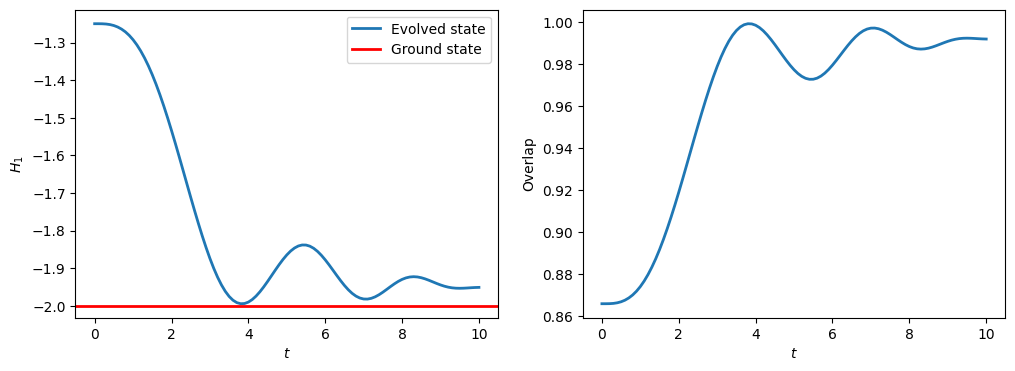

In [180]:
plot_overlaps(T, energy, overlap, state_energy)

Optmized Scheduler

In [202]:
energy = callbacks.Energy(h1)
overlap = callbacks.Overlap(target_state)
params =[1,1]
evolution = models.AdiabaticEvolution(h0, h1, spolynomial, dt=1e-1, callbacks=[energy, overlap])
best_energy, parameters, _ = evolution.minimize(
    params,
)

In [204]:
print(parameters)

[0.98564456 9.5998114 ]


In [213]:
T = 10
final_state = evolution(T)

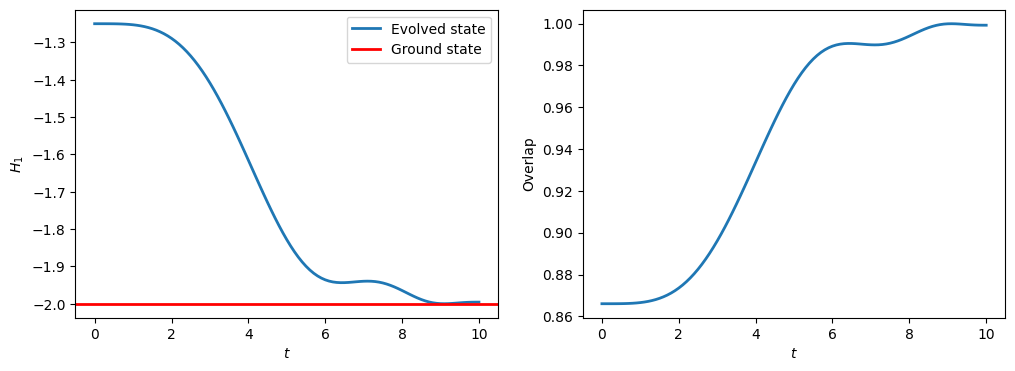

In [214]:
plot_overlaps(T, energy, overlap, state_energy)